##  Answering Business Questions using SQL for Chinook database

In this project we are going to explore and analyze chinook data base. we are going to use modified version of data base which we included in project directory. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store

here is some questions that we are going to answer in this project

1- what is the best genre            
2- employee performance                    
3- best countries by sale                        
4- how many purchases are whole album purchasing vs individual tracks                     

First we are going to import essential libraries and connect to data base also in this cell we defined our necessary functions which we are going to use in our project. at the end of the cell we showed all tables and their names in this database in a table

In [91]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
%matplotlib inline

def run_query(q):
    with sqlite3.connect("chinook.db") as conn:
        return pd.read_sql(q, conn)
    
    
def run_command(c):
    with sqlite3.connect("chinook.db") as conn:
        conn.isolation_level = None
        conn.execute(c)
        

def show_tables():
    q ='''
    SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");
'''
    return run_query(q)
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Best Genres

the chinook signed a contract and they want to see which genre and artist is worse to by and invest for their online shop. in table blow we can see each artists and genre in this contract.


| Artist Name| Genre | 
| --- | --- | 
| Regal | Hip-Hop |
| --- | --- | 
| Red Tone	 | Punk |
| --- | --- | 
| Meteor and the Girls	 | Pop |
| --- | --- | 
| Slim Jim Bites | Blues |

Then we are going to find the best sold genres in USA  and recommend first three one which are in contract our business managers.

In [2]:
best_sold_genre = '''

WITH USA_purches AS
                  (SELECT il.*, c.country
                  FROM customer c
                  INNER JOIN invoice i ON i.customer_id = c.customer_id
                  INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
                  WHERE c.country = "USA"
                  )

SELECT
      g.name genre_name,
      SUM(up.quantity) total_sold,
      CAST(SUM(up.quantity) as float) / CAST((SELECT COUNT(quantity) FROM USA_purches) as float) sold_percentage
FROM USA_purches up
LEFT JOIN track t ON t.track_id = up.track_id
LEFT JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER by 2 DESC
LIMIT 10

'''
run_query(best_sold_genre)

,genre_name,total_sold,sold_percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Text(600,-0.15,'test labele annoate')

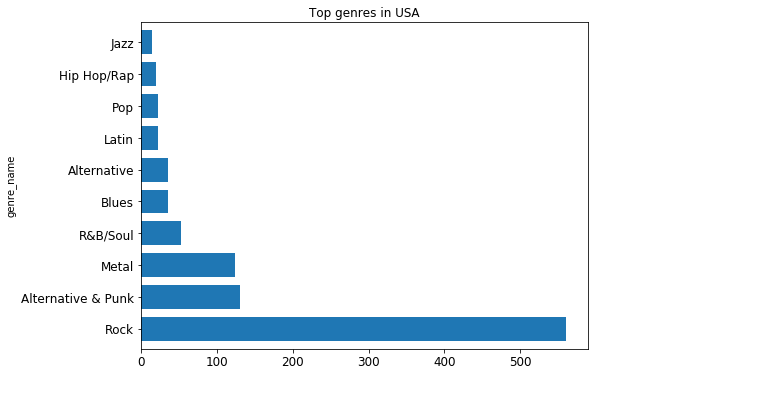

In [3]:
top_genre_usa = run_query(best_sold_genre)
top_genre_usa.set_index("genre_name",drop=True,inplace=True)
ax = top_genre_usa["total_sold"].plot(kind='barh', title ="Top genres in USA", 
                        figsize=(8, 6), legend=False, fontsize=12, 
                        width = 0.75)

ax.annotate("test labele annoate", (600, - 0.15))

As you can see in the table and figure above the best genre in with high sold tracks is ROCK then Alternative & Punk following with metal. But based on our list to choose first three albums we first need to select Alternative & Punk then Blues and then Pop. So we need to purchase for the store from artists :

1- `Red Tone`              
2- `Slim Jim Bites`                   
3-  `Meteor and the Girls`        

## Employee performance

in this section we are going to analyze each sales support agent sales performance as in the query and the code blow

In [4]:
employee_performance = '''
SELECT 
      e.first_name || " " || e.last_name employee_name,
      e.birthdate,
      e.hire_Date,
      SUM(i.total) total_dollar
FROM employee e
LEFT JOIN customer c ON c.support_rep_id = e.employee_id
LEFT JOIN invoice i ON i.customer_id = c.customer_id
WHERE e.title = "Sales Support Agent"
GROUP BY 1
ORDER BY 4 DESC

'''

run_query(employee_performance)

,employee_name,birthdate,hire_date,total_dollar
0,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,1731.51
1,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,1584.00
2,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,1393.92


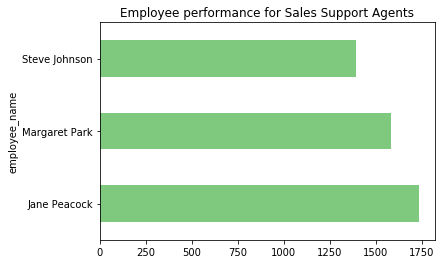

In [5]:
employee_dollar =  run_query(employee_performance)
employee_dollar.set_index("employee_name", inplace = True, drop = True)
employee_dollar["total_dollar"].plot.barh(title = "Employee performance for Sales Support Agents",
                                          colormap=plt.cm.Accent)

As we can see in the table and figure above there are only a bit differences between total amount of dollar for each employee and if you look at their hire data the oldest one has most total dollar amount. there is no relation between their age and their performance in this particular analysis.

## Sales by country

we are going to analyze sales by country like number of customer total sale by dollar for each country in the query blow

In [71]:
country_customer_sales = '''

WITH customer_purches AS
                       (
                       SELECT 
                             c.country,
                             c.customer_id,
                             SUM(i.total) total,
                             COUNT(distinct invoice_id) number_of_order
                       FROM customer c
                       LEFT JOIN invoice i ON i.customer_id = c.customer_id
                       GROUP BY 2
                       ),



     country_customer AS
                       (
                        SELECT 
                               SUM(number_of_order) number_of_order,
                               SUM(total) total,
                               SUM(total_customer) total_customer,
                               CASE
                                    WHEN total_customer = 1 THEN "other"
                                    ELSE country
                               END AS country       
                        FROM (
                             SELECT country,
                                     COUNT(customer_id) total_customer,
                                     SUM(total) total,
                                     SUM(number_of_order) number_of_order
                             FROM customer_purches
                             GROUP by 1
                             ORDER by 2 DESC          
                              ) 
                        GROUP by 4
                        ORDER BY 3 DESC
                        )
                        
SELECT 
      country, 
      total_customer,
      total total_dollar,
      CAST(total as float) / CAST(total_customer as float) customer_lifetime_value,
      number_of_order,
      CAST(total as float) / CAST(number_of_order as float) Average_order        
FROM (
      SELECT 
            cc.*,
            CASE
                WHEN country = "other" THEN 1
                ELSE 0
            END AS sort
      FROM country_customer cc
)

ORDER BY sort



'''





run_query(country_customer_sales)

,country,total_customer,total_dollar,customer_lifetime_value,number_of_order,Average_order
0,USA,13,1040.49,80.037692,131,7.942672
1,Canada,8,535.59,66.948750,76,7.047237
2,Brazil,5,427.68,85.536000,61,7.011148
3,France,5,389.07,77.814000,50,7.781400
4,Germany,4,334.62,83.655000,41,8.161463
5,United Kingdom,3,245.52,81.840000,28,8.768571
6,Czech Republic,2,273.24,136.620000,30,9.108000
7,India,2,183.15,91.575000,21,8.721429
8,Portugal,2,185.13,92.565000,29,6.383793
9,other,15,1094.94,72.996000,147,7.448571


Also here in the code blow we are going to plot the results in the table above to have better  understanding 

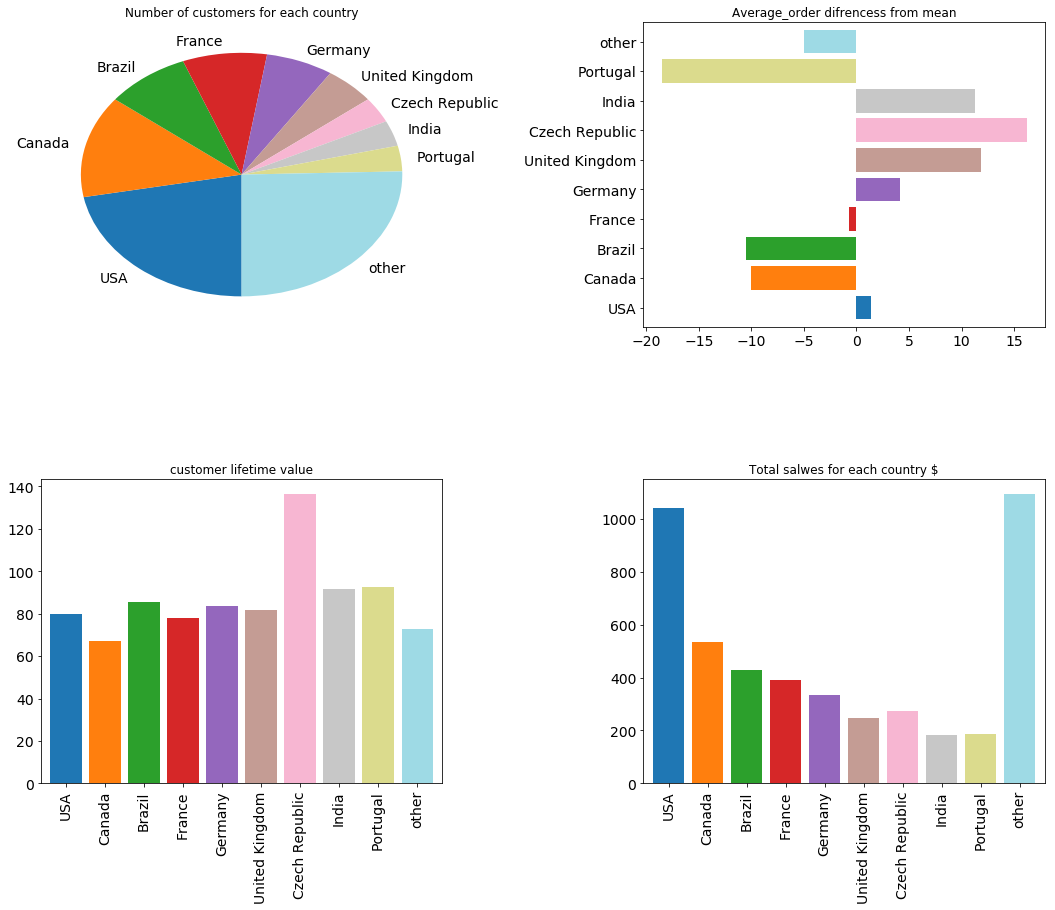

In [132]:
country_sales = run_query(country_customer_sales)
country_sales.set_index("country", drop=True, inplace=True)
colors = [plt.cm.tab20(i) for i in np.linspace(0, 1, country_sales.shape[0])]


fig = plt.figure(figsize=(18, 14))
fig.subplots_adjust(hspace=.5, wspace=.5)



ax1 = fig.add_subplot(2, 2, 1)
country_sales_rename = country_sales["total_customer"].copy().rename('')
country_sales_rename.plot.pie(
    startangle=-90,
    counterclock=False,
    title="Number of customers for each country",
    colormap=plt.cm.tab20,
    ax =ax1,
    fontsize = 14
)


ax2 = fig.add_subplot(2, 2, 2)

average_order = country_sales["Average_order"]
average_order.index.name = ''
difretional = ((average_order * 100) / average_order.mean()) -100

difretional.plot.barh(ax = ax2,
                      title = "Average_order differences from mean",
                      color = colors,
                      fontsize = 14,
                      width = 0.8
                      )

ax3 = fig.add_subplot(2, 2, 3)

customer_lifetime_value = country_sales["customer_lifetime_value"]
customer_lifetime_value.index.name = ''
customer_lifetime_value.plot.bar(ax = ax3,
                      title = "customer lifetime value",
                      color = colors,
                      fontsize = 14,
                      width = 0.8
                      )

ax4 = fig.add_subplot(2, 2, 4)

total_dollar = country_sales["total_dollar"]
total_dollar.index.name = ''
total_dollar.plot.bar(ax = ax4,
                      title = "Total salwes for each country $",
                      color = colors,
                      fontsize = 14,
                      width = 0.8
                      )



as you can see in the plots and tables we have results very clearly for each country. most of customer and sales belong to first USA then Canada. But with looking at the `Average_order differences from mean` plot we could that there are opportunities in countries like `Czech Republic`, `United Kingdom` and `India`. but the data for these countries are very low 2 or 3 customer so we need more data in theses country if we are going to invest in them.

## Album purchases or not

The chinook allows to customer purchases  whole album and purchase a collection of one or more individual tracks.

but recently they want to make some changes in their purchasing policy and it is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

we need to find out how many of purchases are individual tracks vs whole albums, so the management could make decisions based on.

the query blow actually doing this. in this query for each invoice_id we compare if it is whole album purchases or not and we showed the result in the table

In [157]:
album_purches_or_not = '''

WITH track_album AS 
                  (
                  SELECT track_id,
                         album_id
                  FROM track 
                  ),
    first_track_album AS
                 (SELECT il.invoice_id,
                         il.track_id,  
                         t.album_id
                  FROM invoice_line il
                  LEFT JOIN track t ON t.track_id = il.track_id
                  GROUP BY 1
                 )
                 
 
SELECT
      album_purch,
      COUNT(invoice_id) invoice_number
      
FROM
    ( 
    SELECT
          fta.invoice_id,
          CASE
              WHEN 
                  (
                     SELECT ta.track_id FROM track_album ta
                     WHERE ta.album_id = fta.album_id 
                     
                                                       
                     EXCEPT
                     
                     SELECT il.track_id FROM invoice_line il
                     WHERE  fta.invoice_id = il.invoice_id
                     
                   ) IS NULL
                   
                AND
                   (
                       SELECT il.track_id FROM invoice_line il
                       WHERE  fta.invoice_id = il.invoice_id
                      
                      
                      EXCEPT
                      
                       SELECT ta.track_id FROM track_album ta
                       WHERE ta.album_id = fta.album_id 
                      
                   
                   ) IS NULL
                THEN "YES"
                ELSE "NO"
            END AS album_purch
        FROM first_track_album fta
        )
                      
                  
GROUP BY album_purch
'''


run_query(album_purches_or_not)

,album_purch,invoice_number
0,NO,500
1,YES,114


as you can see in the table above most of the purchases are not whole album.


## Conclusion

in this project we explored and analyzed the fictional on-line music shop data to answer some business questions and we acquired these results

1- the best genres that we need to include in our new deal is punk blues and pop and their corresponding artists in contract

2- the employee performances in sales section are same for three of them and the differences is only because  hiring date.

3- the best countries in total customers and sale was USA then Canada. and there is business opportunities in  `Czech Republic`, `United Kingdom` and `India` but we need more the data before we start.

4- most of purchases are individual tracks  vs in compare to whole album purchasing 